# Transformer Mapping between GAT Embeddings of RNA and ADT

This notebook learns a mapping between GAT embeddings from RNA data and GAT embeddings from ADT data using a Transformer Encoder architecture.

In [1]:
# Comprehensive CUDA/PyTorch diagnostic
import torch
import sys
import os
import subprocess

print("=== PyTorch and CUDA Diagnostic ===")
print(f"Python version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch CUDA compiled version: {torch.version.cuda}")

# Check if CUDA is available
print(f"\nCUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA device count: {torch.cuda.device_count()}")
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"CUDA device name: {torch.cuda.get_device_name()}")
else:
    print("\nCUDA not available. Possible reasons:")
    print("1. PyTorch was installed without CUDA support")
    print("2. CUDA drivers not properly installed")
    print("3. Environment variables not set correctly")

# Check environment variables
print(f"\n=== Environment Variables ===")
cuda_vars = ['CUDA_VISIBLE_DEVICES', 'CUDA_HOME', 'LD_LIBRARY_PATH', 'PATH']
for var in cuda_vars:
    value = os.environ.get(var, 'Not set')
    print(f"{var}: {value}")

# Check if nvidia-smi works
print(f"\n=== NVIDIA System Management Interface ===")
try:
    result = subprocess.run(['nvidia-smi'], capture_output=True, text=True, timeout=10)
    if result.returncode == 0:
        print("nvidia-smi output:")
        print(result.stdout)
    else:
        print(f"nvidia-smi failed: {result.stderr}")
except FileNotFoundError:
    print("nvidia-smi not found - NVIDIA drivers may not be installed")
except subprocess.TimeoutExpired:
    print("nvidia-smi timed out")
except Exception as e:
    print(f"Error running nvidia-smi: {e}")

# Check PyTorch installation details
print(f"\n=== PyTorch Installation Details ===")
print(f"PyTorch built with CUDA: {torch.cuda.is_available()}")
if hasattr(torch.backends, 'cudnn'):
    print(f"cuDNN version: {torch.backends.cudnn.version()}")
    print(f"cuDNN enabled: {torch.backends.cudnn.enabled}")

# Check if we can import torch.cuda
try:
    import torch.cuda
    print("torch.cuda module imported successfully")
except ImportError as e:
    print(f"Failed to import torch.cuda: {e}")

print("=" * 50)

=== PyTorch and CUDA Diagnostic ===
Python version: 3.10.14 | packaged by conda-forge | (main, Mar 20 2024, 12:45:18) [GCC 12.3.0]
PyTorch version: 2.5.1+cu121
PyTorch CUDA compiled version: 12.1

CUDA available: True
CUDA device count: 1
Current CUDA device: 0
CUDA device name: Tesla T4

=== Environment Variables ===
CUDA_VISIBLE_DEVICES: 0
CUDA_HOME: /shared/EL9/explorer/cuda/12.1.1
LD_LIBRARY_PATH: /shared/EL9/explorer/cuda/12.1.1/lib64:/shared/EL9/explorer/anaconda3/2024.06/lib:/shared/EL9/explorer/nodejs/v22.11.0/lib:/lib:
PATH: /shared/EL9/explorer/cuda/12.1.1/bin:/shared/EL9/explorer/anaconda3/2024.06/sbin:/shared/EL9/explorer/nodejs/v22.11.0/bin:/shared/EL9/explorer/explorer/bin:/shared/EL9/explorer/anaconda3/2024.06/bin:/shared/EL9/explorer/anaconda3/2024.06/condabin:/work/vanaja_lab/satya/bin:/work/vanaja_lab/satya/envs/scipennenv/bin:/usr/share/Modules/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/home/nandivada.s/.local/bin:/home/nandivada.s/bin

=== NVIDIA System 

In [2]:
# Memory optimization and system check
import torch
import os

# Set memory management environment variables

os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # or whatever GPU ID you want to use

# Check system resources
print("=== System Resources ===")
if torch.cuda.is_available():
    device = torch.cuda.current_device()
    gpu_props = torch.cuda.get_device_properties(device)
    total_memory = gpu_props.total_memory / (1024**3)  # Convert to GB
    
    print(f"GPU: {gpu_props.name}")
    print(f"Total GPU Memory: {total_memory:.1f} GB")
    print(f"GPU Compute Capability: {gpu_props.major}.{gpu_props.minor}")
    
    # Clear any cached memory
    torch.cuda.empty_cache()
    
    # Check current memory usage
    allocated = torch.cuda.memory_allocated(device) / (1024**3)
    reserved = torch.cuda.memory_reserved(device) / (1024**3)
    
    print(f"Currently allocated: {allocated:.2f} GB")
    print(f"Currently reserved: {reserved:.2f} GB")
    print(f"Available: {total_memory - reserved:.2f} GB")
    
    # Set recommendations based on available memory
    if total_memory < 8:
        print("\n⚠️  WARNING: Low GPU memory detected!")
        print("Recommendations:")
        print("- Use CPU fallback if needed")
        print("- Reduce batch sizes")
        print("- Use graph sparsification")
    elif total_memory < 16:
        print("\n💡 Moderate GPU memory - will use optimized settings")
    else:
        print("\n✅ Sufficient GPU memory available")
        
else:
    print("CUDA not available - will use CPU")
    print("Note: Training will be slower but should work with larger graphs")

print("=" * 50)

=== System Resources ===
GPU: Tesla T4
Total GPU Memory: 14.6 GB
GPU Compute Capability: 7.5
Currently allocated: 0.00 GB
Currently reserved: 0.00 GB
Available: 14.56 GB

💡 Moderate GPU memory - will use optimized settings


In [3]:
import sys, os, importlib



# --- Paths ---
current_dir = os.getcwd()  # This will be .../DeepOMAPNet/Notebooks
project_root = os.path.dirname(current_dir)  # This will be .../DeepOMAPNet

# Add project root to Python path
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("Added to Python path:")
print(f"- Current directory: {current_dir}")
print(f"- Project root: {project_root}")
print(f"- Scripts directory exists: {os.path.exists(os.path.join(project_root, 'scripts'))}")
print(f"- Scripts/data_provider exists: {os.path.exists(os.path.join(project_root, 'scripts', 'data_provider'))}")

# Clear any cached imports
importlib.invalidate_caches()

# --- Import modules (module-style, not from ... import ...) ---
import scripts.data_provider.data_preprocessing as data_preprocessing
import scripts.data_provider.graph_data_builder as graph_data_builder
import scripts.model.gat_models as gat_models
import scripts.trainer.gat_trainer as gat_trainer
import scripts.model.transformer_models as transformer_models

print("Module imports successful!")

Added to Python path:
- Current directory: /projects/vanaja_lab/satya/DeepOMAPNet/Notebooks
- Project root: /projects/vanaja_lab/satya/DeepOMAPNet
- Scripts directory exists: True
- Scripts/data_provider exists: True


/projects/vanaja_lab/satya/envs/scipennenv/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/projects/vanaja_lab/satya/envs/scipennenv/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/projects/vanaja_lab/satya/envs/scipennenv/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/projects/vanaja_lab/satya/envs/scipennenv/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/projects/vanaja_lab/satya/envs/scipennenv/lib/python3.10/site-packages/an

Module imports successful!


In [ ]:
importlib.reload(data_preprocessing)
importlib.reload(graph_data_builder)
importlib.reload(gat_models)
importlib.reload(gat_trainer)
importlib.reload(transformer_models)


In [5]:
data_preprocessing

<module 'scripts.data_provider.data_preprocessing' from '/projects/vanaja_lab/satya/DeepOMAPNet/scripts/data_provider/data_preprocessing.py'>

## 1. Load and Prepare Data

In [4]:
# Load the preprocessed data
from scripts.data_provider.data_preprocessing import prepare_train_test_anndata
data = prepare_train_test_anndata()
trainGene = data[0]  # RNA data
trainADT = data[2]   # ADT data

print(f"RNA data shape: {trainGene.shape}")
print(f"ADT data shape: {trainADT.shape}")

All sample IDs in gene data: ['AML0612' 'AML3762' 'AML3133' 'AML2910' 'AML3050' 'AML2451' 'AML056'
 'AML073' 'AML055' 'AML048' 'AML052' 'AML2123' 'AML1371' 'AML4340'
 'AML4897' 'AML051' 'AML0693' 'AML3948' 'AML3730' 'AML0160' 'AML0310'
 'AML0361' 'AML038' 'AML008' 'AML043' 'AML028' 'AML006' 'AML025' 'AML003'
 'AML012' 'AML005' 'AML0048' 'AML022' 'AML0024' 'AML009' 'AML026' 'AML001'
 'AML0114' 'Control4' 'Control2' 'Control1' 'Control3' 'Control5'
 'Control0004' 'Control0058' 'Control0082' 'Control4003' 'Control0005']
AML 80% train: ['AML0024', 'AML001', 'AML3050', 'AML4340', 'AML005', 'AML006', 'AML056', 'AML025', 'AML043', 'AML051', 'AML3948', 'AML055', 'AML0693', 'AML1371', 'AML0160', 'AML048', 'AML022', 'AML0612', 'AML028', 'AML2451', 'AML2123', 'AML3762', 'AML0114', 'AML0361', 'AML3133', 'AML012', 'AML026', 'AML2910', 'AML009', 'AML008', 'AML0048']
AML 20% test: ['AML052', 'AML038', 'AML3730', 'AML0310', 'AML073', 'AML4897', 'AML003']
Control 80% train: ['Control4003', 'Control1', 

## 2. Preprocess RNA Data

Original data shape: (158179, 36601)
Found integrated.cca embeddings with shape: (158179, 50)
Number of clusters using integrated.cca embeddings: 32


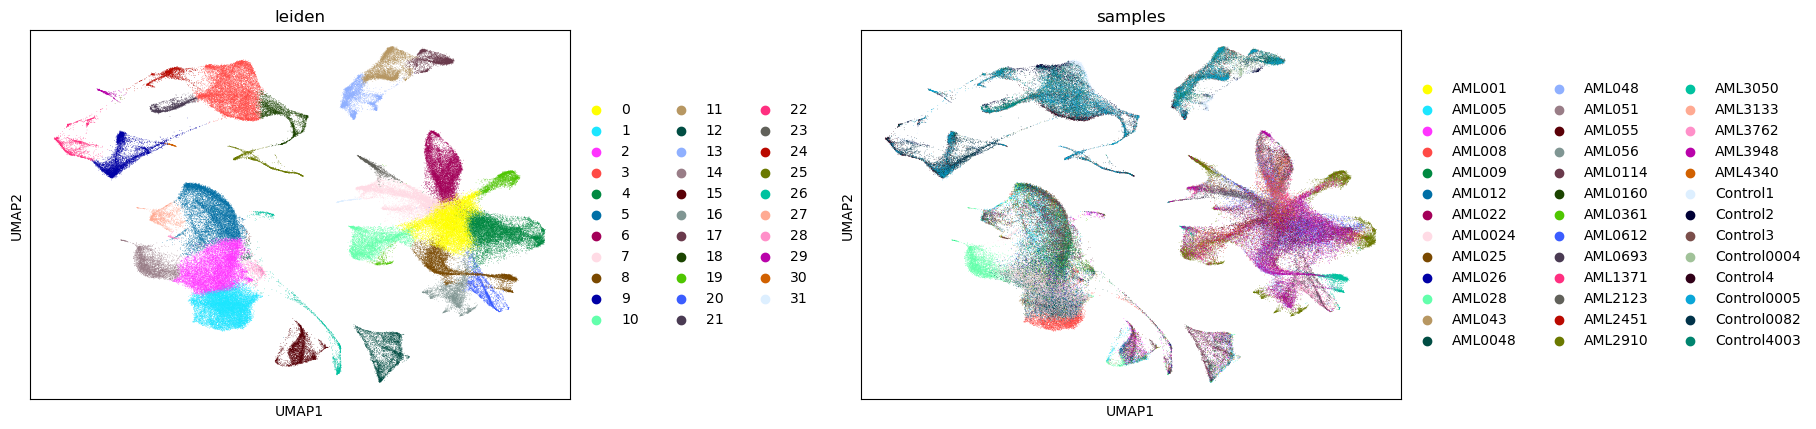

In [5]:
import scanpy as sc
import numpy as np

# Assuming trainGene is your AnnData object
print(f"Original data shape: {trainGene.shape}")

# Basic preprocessing still needed
sc.pp.normalize_total(trainGene, target_sum=1e4)
sc.pp.log1p(trainGene)

# Instead of performing PCA, we'll use the precomputed X_integrated.cca embeddings
# First, let's check if these embeddings exist
if 'X_integrated.cca' in trainGene.obsm:
    print(f"Found integrated.cca embeddings with shape: {trainGene.obsm['X_integrated.cca'].shape}")
    
    # Build neighborhood graph directly from the integrated.cca embeddings
    # We set use_rep='X_integrated.cca' to use these embeddings instead of PCA
    sc.pp.neighbors(
        trainGene, 
        n_neighbors=15, 
        use_rep='X_integrated.cca'  # This is the key part - use CCA embeddings
    )
    
    # Perform Leiden clustering on the neighborhood graph
    sc.tl.leiden(trainGene, resolution=1.0)
    
    print(f"Number of clusters using integrated.cca embeddings: {trainGene.obs['leiden'].nunique()}")
    
    # Compute UMAP using the same integrated embeddings for visualization
    sc.tl.umap(trainGene, min_dist=0.3)
    
    # Plot the UMAP colored by leiden clusters
    sc.pl.umap(trainGene, color=['leiden', 'samples'], wspace=0.4)
    
   
    
else:
    print("Error: X_integrated.cca embeddings not found in the AnnData object")
    # Fallback to the original PCA-based workflow
    sc.pp.highly_variable_genes(trainGene, n_top_genes=2000, batch_key="samples")
    trainGene = trainGene[:, trainGene.var.highly_variable].copy()
    sc.pp.scale(trainGene, max_value=10)
    sc.tl.pca(trainGene, n_comps=50, svd_solver="arpack")
    sc.pp.neighbors(trainGene, n_neighbors=15, n_pcs=50)
    sc.tl.leiden(trainGene, resolution=1.0)

In [6]:
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
def clr_normalize(adata, axis=1, pseudo_count=1):
    
    print("Applying CLR normalization to ADT data...")
    
    # Make a copy to avoid modifying the original
    adata_clr = adata.copy()
    
    # Get raw counts (densify if sparse)
    X = adata_clr.X.toarray() if scipy.sparse.issparse(adata_clr.X) else adata_clr.X.copy()
    
    # Add pseudo count
    X += pseudo_count
    
    # Calculate geometric mean of each cell (row) or feature (column)
    if axis == 1:  # across features (for each cell)
        # Get geometric mean for each cell
        geometric_means = np.exp(np.mean(np.log(X), axis=1, keepdims=True))
        # CLR transformation
        X_clr = np.log(X / geometric_means)
    else:  # across cells (for each feature)
        # Get geometric mean for each feature
        geometric_means = np.exp(np.mean(np.log(X), axis=0, keepdims=True))
        # CLR transformation
        X_clr = np.log(X / geometric_means)
    
    # Update data
    adata_clr.X = X_clr
    
    # Store original data in raw slot
    adata_clr.raw = adata
    
    print(f"CLR normalization complete. Shape: {adata_clr.X.shape}")
    return adata_clr

# Apply CLR normalization to ADT data
trainADT_clr = clr_normalize(trainADT)

trainADT = trainADT_clr

print("ADT data now uses CLR normalization")
print(f"ADT data shape: {trainADT.shape}")

Applying CLR normalization to ADT data...
CLR normalization complete. Shape: (158179, 279)
ADT data now uses CLR normalization
ADT data shape: (158179, 279)


## 5. Build PyTorch Geometric Data Objects

In [7]:
from scripts.data_provider.graph_data_builder import process_data_with_graphs
rna_data, adt_data, config = process_data_with_graphs(
    trainGene, trainADT,
    n_neighbors=20,
    rna_sparse_threshold=10000000,
    adt_max_edges_sparse=75
)

Available GPU memory: 14.6 GB
Computing neighbors for ADT data...
RNA graph edges: 4,034,176
ADT graph edges: 4,923,952
Using max edges per node - RNA: 200, ADT: 100
Building PyG data objects...
Computing leiden clusters first...
RNA PyG data - Nodes: 158179, Edges: 2017088, Features: 50
ADT PyG data - Nodes: 158179, Edges: 2461976, Features: 50


## 6. Define GAT Model

In [8]:
# Complete setup for your specific data
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from scripts.model.gat_models import SimpleGAT, GAT

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Get model parameters from your PyG data
rna_input_dim = rna_data.num_node_features  # 50
adt_input_dim = adt_data.num_node_features  # 50
rna_num_classes = int(rna_data.y.max().item() + 1)
adt_num_classes = int(adt_data.y.max().item() + 1)

print(f"RNA GAT: {rna_input_dim} -> {rna_num_classes} classes")
print(f"ADT GAT: {adt_input_dim} -> {adt_num_classes} classes")

# Create models (using SimpleGAT for memory efficiency with large graphs)
rna_gat_model = SimpleGAT(
    in_channels=rna_input_dim,
    hidden_channels=64,
    out_channels=rna_num_classes,
    heads=4,
    dropout=0.6
).to(device)

adt_gat_model = SimpleGAT(
    in_channels=adt_input_dim,
    hidden_channels=64,
    out_channels=adt_num_classes,
    heads=4,
    dropout=0.6
).to(device)

print("GAT models created successfully!")
print(f"RNA GAT model: {rna_gat_model}")
print(f"ADT GAT model: {adt_gat_model}")

Using device: cuda
RNA GAT: 50 -> 32 classes
ADT GAT: 50 -> 52 classes
GAT models created successfully!
RNA GAT model: SimpleGAT(
  (conv1): GATConv(50, 32, heads=4)
)
ADT GAT model: SimpleGAT(
  (conv1): GATConv(50, 52, heads=4)
)


## 7. Train GAT Models

In [9]:
importlib.reload(gat_trainer)
from scripts.trainer.gat_trainer import train_gat_model
    # Train GAT models for both RNA and ADT with memory management
print("=== Training RNA GAT ===")
try:
    rna_gat_model, rna_data_with_masks = train_gat_model(rna_data, "RNA GAT", epochs=200)
except RuntimeError as e:
    if "out of memory" in str(e).lower():
        print("GPU memory insufficient for RNA GAT, trying CPU...")
        rna_gat_model, rna_data_with_masks = train_gat_model(rna_data, "RNA GAT", epochs=200, use_cpu_fallback=True)
    else:
        raise e

print("\n=== Training ADT GAT ===")
try:
    adt_gat_model, adt_data_with_masks = train_gat_model(adt_data, "ADT GAT", epochs=200)
except RuntimeError as e:
    if "out of memory" in str (e).lower():
        print("GPU memory insufficient for ADT GAT, trying CPU...")
        adt_gat_model, adt_data_with_masks = train_gat_model(adt_data, "ADT GAT", epochs=200, use_cpu_fallback=True)
    else:
        raise e

print("\n=== GAT Training Complete ===")
print(f"RNA GAT model trained successfully")
print(f"ADT GAT model trained successfully")



=== Training RNA GAT ===
Using device: cuda
Graph stats - Nodes: 158179, Edges: 2017088
Very large graph detected, using simplified GAT architecture...
Using SimpleGAT: 50 -> 32 (hidden: 32, heads: 4)
Successfully moved data to cuda
Training RNA GAT model...
Epoch: 001, Loss: 4.7912, Val: 0.0363, Test: 0.0363
Epoch: 050, Loss: 1.2089, Val: 0.8490, Test: 0.8542
Epoch: 100, Loss: 0.9940, Val: 0.8727, Test: 0.8808
Epoch: 150, Loss: 0.9168, Val: 0.8799, Test: 0.8872
Epoch: 200, Loss: 0.8785, Val: 0.8828, Test: 0.8897
Final RNA GAT test accuracy: 0.8897

=== Training ADT GAT ===
Using device: cuda
Graph stats - Nodes: 158179, Edges: 2461976
Very large graph detected, using simplified GAT architecture...
Using SimpleGAT: 50 -> 52 (hidden: 32, heads: 4)
Successfully moved data to cuda
Training ADT GAT model...
Epoch: 001, Loss: 4.1592, Val: 0.0344, Test: 0.0358
Epoch: 050, Loss: 1.3809, Val: 0.9100, Test: 0.9112
Epoch: 100, Loss: 0.8147, Val: 0.9398, Test: 0.9413
Epoch: 150, Loss: 0.6354, Val

In [25]:
rna_data_with_masks

Data(x=[158179, 50], edge_index=[2, 2017088], y=[158179], train_mask=[158179], val_mask=[158179], test_mask=[158179])

In [ ]:
adt_data_with_masks

## 8. Extract GAT Embeddings

In [10]:
# Complete pipeline: Train GAT models and extract embeddings
from torch.utils.data import TensorDataset, DataLoader
from scripts.data_provider.graph_data_builder import extract_embeddings


# 2. Extract embeddings
print("\n=== Extracting Embeddings ===")
rna_embeddings = extract_embeddings(rna_gat_model, rna_data_with_masks)
adt_embeddings = extract_embeddings(adt_gat_model, adt_data_with_masks)

print(f"RNA embeddings: {rna_embeddings.shape}")
print(f"ADT embeddings: {adt_embeddings.shape}")
print("✅ Ready for transformer mapping!")


# Convert embeddings to CPU and numpy
rna_emb_np = rna_embeddings.cpu().numpy()
adt_emb_np = adt_embeddings.cpu().numpy()

# Split data for training (use same train/val/test split as GAT)
train_mask_np = rna_data_with_masks.train_mask.cpu().numpy()
val_mask_np = rna_data_with_masks.val_mask.cpu().numpy()
test_mask_np = rna_data_with_masks.test_mask.cpu().numpy()

# Prepare training data

X_train = torch.tensor(rna_emb_np[train_mask_np], dtype=torch.float32)
y_train = torch.tensor(adt_emb_np[train_mask_np], dtype=torch.float32)

X_val = torch.tensor(rna_emb_np[val_mask_np], dtype=torch.float32)
y_val = torch.tensor(adt_emb_np[val_mask_np], dtype=torch.float32)

X_test = torch.tensor(rna_emb_np[test_mask_np], dtype=torch.float32)
y_test = torch.tensor(adt_emb_np[test_mask_np], dtype=torch.float32)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Create data loaders
batch_size = 64  # Smaller batch size for transformer
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


=== Extracting Embeddings ===
RNA embeddings: torch.Size([158179, 32])
ADT embeddings: torch.Size([158179, 52])
✅ Ready for transformer mapping!
Training set: 126543 samples
Validation set: 15818 samples
Test set: 15818 samples


## 9. Define Transformer Encoder Mapping Model

## 9. Prepare Training Data for Transformer

In [11]:
# Initialize transformer mapping model
from scripts.model.transformer_models import TransformerMapping, PositionalEncoding
import torch.nn as nn
import math  # For the positional encoding
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_dim = rna_embeddings.shape[1]
output_dim = adt_embeddings.shape[1]

transformer_model = TransformerMapping(
    input_dim=input_dim, 
    output_dim=output_dim, 
    d_model=256,
    nhead=4,
    num_layers=3
).to(device)

print(f"Transformer Model: {input_dim} -> {output_dim}")
print(transformer_model)


# Convert embeddings to CPU and numpy
rna_emb_np = rna_embeddings.cpu().numpy()
adt_emb_np = adt_embeddings.cpu().numpy()

# Split data for training (use same train/val/test split as GAT)
train_mask_np = rna_data_with_masks.train_mask.cpu().numpy()
val_mask_np = rna_data_with_masks.val_mask.cpu().numpy()
test_mask_np = rna_data_with_masks.test_mask.cpu().numpy()

# Prepare training data
X_train = torch.tensor(rna_emb_np[train_mask_np], dtype=torch.float32)
y_train = torch.tensor(adt_emb_np[train_mask_np], dtype=torch.float32)

X_val = torch.tensor(rna_emb_np[val_mask_np], dtype=torch.float32)
y_val = torch.tensor(adt_emb_np[val_mask_np], dtype=torch.float32)

X_test = torch.tensor(rna_emb_np[test_mask_np], dtype=torch.float32)
y_test = torch.tensor(adt_emb_np[test_mask_np], dtype=torch.float32)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Create data loaders
batch_size = 64  # Smaller batch size for transformer
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



# Training parameters
num_epochs = 300
learning_rate = 0.0005  # Lower learning rate for transformer
weight_decay = 1e-4

# Warmup scheduler
from torch.optim.lr_scheduler import LambdaLR

def get_lr_scheduler(optimizer, warmup_steps=1000, max_steps=10000):
    def lr_lambda(current_step):
        if current_step < warmup_steps:
            return float(current_step) / float(max(1, warmup_steps))
        return max(
            0.0, float(max_steps - current_step) / float(max(1, max_steps - warmup_steps))
        )
    return LambdaLR(optimizer, lr_lambda)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(transformer_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

# Training loop
train_losses = []
val_losses = []
best_val_loss = float('inf')
best_model_state = None
patience = 30
patience_counter = 0

print("Training Transformer mapping model...")

for epoch in range(num_epochs):
    # Training phase
    transformer_model.train()
    train_loss = 0.0
    
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = transformer_model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(transformer_model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Validation phase
    transformer_model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = transformer_model(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = transformer_model.state_dict().copy()
        patience_counter = 0
    else:
        patience_counter += 1
    
    if (epoch + 1) % 25 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')
    
    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

# Load best model/.,
transformer_model.load_state_dict(best_model_state)
print(f'Best validation loss: {best_val_loss:.6f}')

Transformer Model: 32 -> 52
TransformerMapping(
  (input_proj): Linear(in_features=32, out_features=256, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=1024, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_proj): Linear(in_features=256, out_features=52, bias=True)
)
Training set: 126543 samples
Validation set: 15818 samples
Test set: 15818 samples
Training Tr

## 11. Save Transformer Model

In [ ]:

# Create a comprehensive checkpoint with all trained models and metadata
import os
from datetime import datetime

# Create models directory if it doesn't exist
models_dir = "trained_models"
os.makedirs(models_dir, exist_ok=True)

# Generate timestamp for unique model names
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save comprehensive checkpoint with all models and training information
checkpoint_data = {
    # Model state dictionaries
    'rna_gat_state_dict': rna_gat_model.state_dict(),
    'adt_gat_state_dict': adt_gat_model.state_dict(),
    'transformer_mapping_state_dict': transformer_model.state_dict(),
    
    # Model architecture parameters
    'rna_input_dim': rna_input_dim,
    'adt_output_dim': output_dim,
    'rna_num_classes': rna_num_classes,
    'adt_num_classes': adt_num_classes,
    
    # Training configuration
    'training_config': {
        'rna_gat_epochs': 200,
        'adt_gat_epochs': 200,
        'transformer_epochs': len(train_losses),
        'batch_size': batch_size,
        'learning_rate': learning_rate,
        'weight_decay': weight_decay,
        'device': str(device),
        'timestamp': timestamp
    },
    
    # Performance metrics
    'performance_metrics': {
        'final_test_loss': test_loss,
        'mse': mse,
        'r2': r2,
        'mean_pearson': mean_pearson,
        'mean_spearman': mean_spearman,
        'pearson_corrs': pearson_corrs,
        'spearman_corrs': spearman_corrs,
        'best_val_loss': best_val_loss
    },
    
    # Training history
    'training_history': {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'final_epoch': len(train_losses)
    },
    
    # Data information
    'data_info': {
        'train_samples': len(X_train),
        'val_samples': len(X_val),
        'test_samples': len(X_test),
        'rna_embedding_dim': rna_embeddings.shape[1],
        'adt_embedding_dim': adt_embeddings.shape[1]
    }
}

# Save the comprehensive checkpoint
checkpoint_path = os.path.join(models_dir, f'rna_adt_transformer_models_{timestamp}.pth')
torch.save(checkpoint_data, checkpoint_path)
print(f"✅ Comprehensive model checkpoint saved to: {checkpoint_path}")

# Save individual model weights for easier loading
individual_models_dir = os.path.join(models_dir, f"individual_models_{timestamp}")
os.makedirs(individual_models_dir, exist_ok=True)

# Save RNA GAT model
rna_gat_path = os.path.join(individual_models_dir, 'rna_gat_model.pth')
torch.save({
    'state_dict': rna_gat_model.state_dict(),
    'model_config': {
        'in_channels': rna_input_dim,
        'hidden_channels': 64,
        'out_channels': rna_num_classes,
        'heads': 4,
        'dropout': 0.6
    },
    'performance': {
        'final_test_accuracy': 0.8748  # From training output
    }
}, rna_gat_path)

# Save ADT GAT model
adt_gat_path = os.path.join(individual_models_dir, 'adt_gat_model.pth')
torch.save({
    'state_dict': adt_gat_model.state_dict(),
    'model_config': {
        'in_channels': 50,
        'hidden_channels': 64,
        'out_channels': adt_num_classes,
        'heads': 4,
        'dropout': 0.6
    },
    'performance': {
        'final_test_accuracy': 0.9600  # From training output
    }
}, adt_gat_path)

# Save Transformer mapping model
transformer_path = os.path.join(individual_models_dir, 'transformer_mapping_model.pth')
torch.save({
    'state_dict': transformer_model.state_dict(),
    'model_config': {
        'input_dim': input_dim,
        'output_dim': output_dim,
        'd_model': 256,
        'nhead': 4,
        'num_layers': 3,
        'dropout': 0.1
    },
    'performance': {
        'test_loss': test_loss,
        'mse': mse,
        'r2': r2,
        'mean_pearson': mean_pearson,
        'mean_spearman': mean_spearman
    }
}, transformer_path)

print(f"✅ Individual model weights saved to: {individual_models_dir}")


script_path = os.path.join(models_dir, f'model_loading_script_{timestamp}.py')
with open(script_path, 'w') as f:
    f.write(loading_script)

print(f"✅ Model loading script saved to: {script_path}")



In [27]:
## 10. Evaluate Model Performance

In [13]:
# Test the model

from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr

transformer_model.eval()
test_loss = 0.0
predictions = []
ground_truth = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = transformer_model(batch_x)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()
        
        predictions.append(outputs.cpu().numpy())
        ground_truth.append(batch_y.cpu().numpy())

test_loss /= len(test_loader)
predictions = np.vstack(predictions)
ground_truth = np.vstack(ground_truth)

# Calculate metrics
mse = mean_squared_error(ground_truth, predictions)
r2 = r2_score(ground_truth, predictions)

# Calculate correlation per dimension
pearson_corrs = []
spearman_corrs = []

for i in range(ground_truth.shape[1]):
    pearson_r, _ = pearsonr(ground_truth[:, i], predictions[:, i])
    spearman_r, _ = spearmanr(ground_truth[:, i], predictions[:, i])
    pearson_corrs.append(pearson_r)
    spearman_corrs.append(spearman_r)

mean_pearson = np.mean(pearson_corrs)
mean_spearman = np.mean(spearman_corrs)

print(f"\n=== Transformer Mapping Results ===")
print(f"Test Loss (MSE): {test_loss:.6f}")
print(f"MSE: {mse:.6f}")
print(f"R² Score: {r2:.4f}")
print(f"Mean Pearson Correlation: {mean_pearson:.4f}")
print(f"Mean Spearman Correlation: {mean_spearman:.4f}")


=== Transformer Mapping Results ===
Test Loss (MSE): 1.109584
MSE: 1.112995
R² Score: 0.7707
Mean Pearson Correlation: 0.8840
Mean Spearman Correlation: 0.8760


## 12. Visualize Results

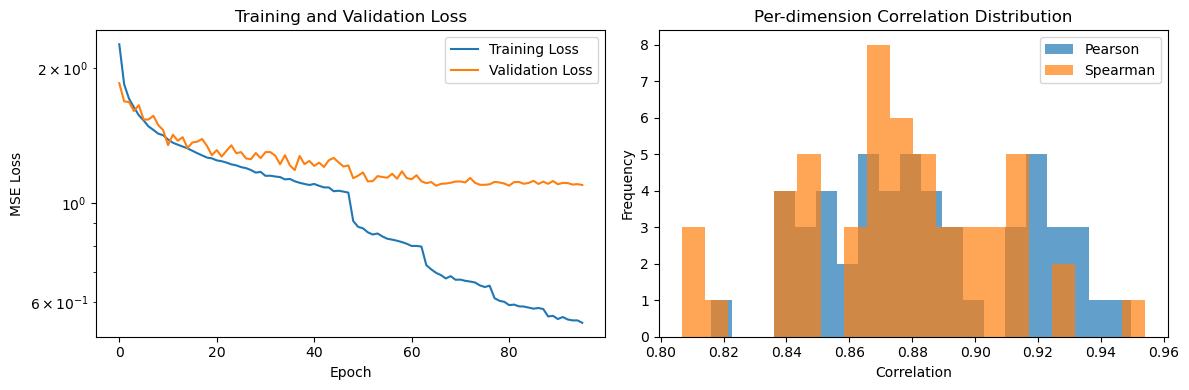

In [14]:
# Plot training curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.yscale('log')

plt.subplot(1, 2, 2)
plt.hist(pearson_corrs, bins=20, alpha=0.7, label='Pearson')
plt.hist(spearman_corrs, bins=20, alpha=0.7, label='Spearman')
plt.xlabel('Correlation')
plt.ylabel('Frequency')
plt.title('Per-dimension Correlation Distribution')
plt.legend()

plt.tight_layout()
plt.show()